MovieWriter ffmpeg unavailable; using Pillow instead.


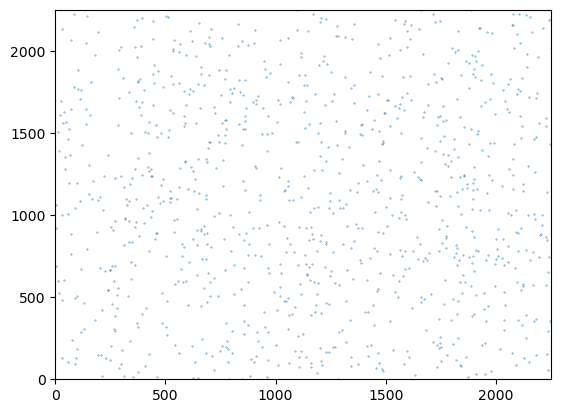

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import imageio

uw = 0.2       # lower wall velocity
Tw = 1         # wall temperature
n0 = 0.001     # density
N = 1000      # number of sampling particles
Nsim = 3       # number of simulations to run
Ncell = 50     # number of cells
Nmft = 20      # number of mean-free times to run simulation

Nt = 20                  # number of time steps (25 per mean-free time)
lambda_mfp = 1 / (np.sqrt(2) * np.pi * n0)    # mean free path
Lz = 10 * lambda_mfp               # height of box
Kn = lambda_mfp / Lz               # Knudsen number
v_mean = (2 / np.sqrt(np.pi)) * np.sqrt(2 * Tw)  # mean speed
tau = lambda_mfp / v_mean          # mean-free time
dt = Nmft * tau / Nt               # timestep
dz = Lz / Ncell                    # cell height
vol = Lz * dz * dz / Ncell         # cell volume
Ne = n0 * Lz * dz * dz / Nsim      # number of real particles each sampling particle represents

# Create initial positions and velocities
x = dz * np.random.random(N)
y = dz * np.random.random(N)
z = Lz * np.random.random(N)
vx = np.random.normal(0, Tw, N)
vy = np.random.normal(0, Tw, N)
vz = np.random.normal(0, Tw, N)

# Create the figure and scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter([], [], s=0.1)

# Set the limits of the plot
ax.set_xlim(0, Lz)
ax.set_ylim(0, Lz)
frames=[]
def update(frame):
    """Update function for animation"""
    global x, y, z, scatter

    # Evolve
    for i in range(Nt):
        # Drift
        x += dt * vx
        y += dt * vy
        z += dt * vz

        # Apply periodic boundary conditions
        x = np.mod(x, Lz)
        y = np.mod(y, Lz)
        z = np.mod(z, Lz)

        # Collide specular wall (z=Lz)
        # Trace the straight-line trajectory to the top wall, bounce it back
        hit_top = z > Lz
        dt_ac = (z[hit_top] - Lz) / vz[hit_top]  # time after collision
        vz[hit_top] = -vz[hit_top]  # reverse normal component of velocity
        z[hit_top] = Lz + dt_ac * vz[hit_top]
        # collide thermal wall (z=0)
        # reset velocity to a biased maxwellian upon impact
        hit_bot = z < 0
        dt_ac = z[hit_bot] / vz[hit_bot]
        x[hit_bot] -= dt_ac * vx[hit_bot]
        y[hit_bot] -= dt_ac * vy[hit_bot]
        Nbot = np.sum( hit_bot )
        vx[hit_bot] = np.sqrt(Tw) * np.random.normal(0, 1, Nbot) 
        vy[hit_bot] = np.sqrt(Tw) * np.random.normal(0, 1, Nbot) + uw
        vz[hit_bot] = np.sqrt( -2 * Tw * np.log(np.random.random(Nbot)) )
        
        x[hit_bot] += dt_ac * vx[hit_bot]
        y[hit_bot] += dt_ac * vy[hit_bot]
        z[hit_bot]  = dt_ac * vz[hit_bot]

    scatter.set_offsets(np.column_stack((x, y)))




# Define the animation
animation = FuncAnimation(fig, update, frames=500, interval=200)
# Display the animation
animation.save('Simulation.gif', writer='ffmpeg')

# Close the figure window